# Deportations 1938 - citizenship

This notebook uses geospatial queries to generate citizenship statistic for the database of deportees from Slovakia in November 1938.

It uses the database compiled from lists in Slovak archives; citizenship needs to be inferred from very diverse types of information, most importantly from the statement of domicile (domovské práva, Heimatsrecht).

The notebook starts from a list of deportees which include Geonames links for the domicile (including state citizenship), extracts coordinates from Geonames and after loading border dataset(s), performs a spatial join to sort domiciles into state territory, and hence the attributed citizenship.

The notebook is an upgrade of a series of steps in PostgreSQL described in an [earlier article](https://blog.ehri-project.eu/2019/12/12/spatial-queries-first-deportations-slovakia/) in the EHRI Document Blog.

Make sure all needed modules are installed.

In [56]:
!pip3 install pandas
!pip3 install geopandas
!pip3 install xmltodict
!pip3 install pyarango
# !pip3 install mapclassify

     |████████████████████████████████| 26.7 MB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 41.6 MB 211 kB/s eta 0:00:01
     |████████████████████████████████| 306 kB 56.4 MB/s eta 0:00:01


Include all necessary libraries and tools. In particular, we rely on Geopandas packages to work with data and conduct spatial joins.

In [83]:
import pandas as pd
import geopandas as gpd
from urllib.request import urlopen
import xmltodict
import json
from pyArango.connection import *
import arangoconf # contains login credentials for Arangodb (adapt and rename arangoconf.py.default)
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

The research database codes places of domicile or information about citizenship as links to Geonames records.

In [6]:
# Read CSV with data
geodf = pd.read_csv('slovdep/slovedep_domicile.csv')
geodf.dropna(axis=0, how="any", inplace=True)
geodf.head()

,location,domicile_citizenship,domicile_geo
0,Žilina,Opava,https://www.geonames.org/3068927/opava.html
1,Michalovce,Maďarsko,https://www.geonames.org/719819/hungary.html
2,Sabinov,polská,https://www.geonames.org/798544/republic-of-po...
3,Sabinov,polská,https://www.geonames.org/798544/republic-of-po...
4,Žilina,Opava,https://www.geonames.org/3068927/opava.html


In [13]:
# Get unique Geonames links (especially important in order to avoid Geonames traffic limits)
gnames = geodf.domicile_geo.unique()
gnamesdf = pd.DataFrame(gnames)
gnamesdf.head()

,0
0,https://www.geonames.org/3068927/opava.html
1,https://www.geonames.org/719819/hungary.html
2,https://www.geonames.org/798544/republic-of-po...
3,https://www.geonames.org/776458/baligrod.html
4,https://www.geonames.org/723010/aggtelek.html


In [17]:
# Connect to Arango database to locally store Geonames data (create configured collection if it doesn't exist yet)
conn = Connection(username=arangoconf.username, password=arangoconf.password)
db = conn[arangoconf.arangodb]
try:
    coll = db[arangoconf.arangocoll]
except:
    coll = db.createCollection(name=arangoconf.arangocoll)

Extract coordinates (and other metadata) from Geonames and save them in a local database. I have used Arangodb and convert the Geonames RDF (XML) response to JSON to save it locally.

In [18]:
#for index, row in geodf.iterrows(): # if running with iterrows, you need to access the fields via their names, such as row['Geonames']
for row in gnamesdf.head(5000).itertuples():
    print(row[1])
        
    # extract Geonames ID
    if row[1].startswith('https://www.geonames.org/'):
        gid = row[1].split('/')[3]
        
        # check if the Geonames record is already in Arangodb
        try:
            olddoc = coll[gid]
        except:
            rdfurl = 'https://sws.geonames.org/' + gid + '/about.rdf'
            rdf = urlopen(rdfurl)
            rdfjson = xmltodict.parse(rdf)

            # insert full json to Arango
            doc = coll.createDocument(rdfjson)
            doc._key = gid
            doc.save()

https://www.geonames.org/3068927/opava.html
https://www.geonames.org/719819/hungary.html
https://www.geonames.org/798544/republic-of-poland.html
https://www.geonames.org/776458/baligrod.html
https://www.geonames.org/723010/aggtelek.html
https://www.geonames.org/2917509/gribow.html
https://www.geonames.org/723846/poprad.html
https://www.geonames.org/8505031/czechoslovakia.html
https://www.geonames.org/2761369/vienna.html
https://www.geonames.org/3058472/nove-zamky.html
https://www.geonames.org/724377/krompachy.html
https://www.geonames.org/667227/sighetu-marmatiei.html
https://www.geonames.org/3059448/kolarovo.html
https://www.geonames.org/798549/romania.html
https://www.geonames.org/3059101/levice.html
https://www.geonames.org/2921044/federal-republic-of-germany.html
https://www.geonames.org/723090/zborov.html
https://www.geonames.org/707559/irshava.html
https://www.geonames.org/706173/khudl-ovo.html
https://www.geonames.org/2782113/republic-of-austria.html
https://www.geonames.org/305

https://www.geonames.org/3079336/bilovec.html
https://www.geonames.org/3061186/banska-bystrica.html
https://www.geonames.org/720568/gelenes.html
https://www.geonames.org/712023/bobovo.html
https://www.geonames.org/723358/trebisov.html
https://www.geonames.org/3057140/trencin.html
https://www.geonames.org/691650/ternopil.html
https://www.geonames.org/761168/przemysl.html
https://www.geonames.org/687869/zakarpattia-oblast.html
https://www.geonames.org/3057197/tisovec.html
https://www.geonames.org/3073803/karlovy-vary.html
https://www.geonames.org/3078610/brno.html
https://www.geonames.org/3058579/namestovo.html
https://www.geonames.org/3075050/hostka.html
https://www.geonames.org/704778/koson.html
https://www.geonames.org/3056940/velicna.html
https://www.geonames.org/3067580/prerov.html
https://www.geonames.org/770237/jata.html
https://www.geonames.org/3063886/tuchyne.html
https://www.geonames.org/3043293/vac.html
https://www.geonames.org/692431/stremil-che.html
https://www.geonames.org/

In [36]:
domiciles = []
for row in gnamesdf.head(5000).itertuples():
    print(row[1])
        
    # extract Geonames ID
    if row[1].startswith('https://www.geonames.org/'):
        gid = row[1].split('/')[3]
        
        # check if the Geonames record is already in Arangodb
        try:
            olddoc = coll[gid]
        except:
            print("Error: Geonames record not in local database.")
        
        lat = olddoc["rdf:RDF"]["gn:Feature"]["wgs84_pos:lat"]
        lon = olddoc["rdf:RDF"]["gn:Feature"]["wgs84_pos:long"]
        print("lat: " + lat + ", lon: " + lon)
        domiciles.append([row[1], lat, lon])

dom = np.array(domiciles)

https://www.geonames.org/3068927/opava.html
lat: 49.93866, lon: 17.90257
https://www.geonames.org/719819/hungary.html
lat: 47, lon: 20
https://www.geonames.org/798544/republic-of-poland.html
lat: 52, lon: 20
https://www.geonames.org/776458/baligrod.html
lat: 49.3309, lon: 22.28566
https://www.geonames.org/723010/aggtelek.html
lat: 48.46667, lon: 20.51667
https://www.geonames.org/2917509/gribow.html
lat: 53.94841, lon: 13.48932
https://www.geonames.org/723846/poprad.html
lat: 49.06144, lon: 20.29798
https://www.geonames.org/8505031/czechoslovakia.html
lat: 50.08292, lon: 14.46672
https://www.geonames.org/2761369/vienna.html
lat: 48.20849, lon: 16.37208
https://www.geonames.org/3058472/nove-zamky.html
lat: 47.98544, lon: 18.16195
https://www.geonames.org/724377/krompachy.html
lat: 48.91447, lon: 20.87514
https://www.geonames.org/667227/sighetu-marmatiei.html
lat: 47.93195, lon: 23.88603
https://www.geonames.org/3059448/kolarovo.html
lat: 47.92294, lon: 17.98467
https://www.geonames.org/7

lat: 48.62858, lon: 21.71954
https://www.geonames.org/3057140/trencin.html
lat: 48.89452, lon: 18.04436
https://www.geonames.org/691650/ternopil.html
lat: 49.55404, lon: 25.59067
https://www.geonames.org/761168/przemysl.html
lat: 49.78498, lon: 22.76728
https://www.geonames.org/687869/zakarpattia-oblast.html
lat: 48.62645, lon: 22.28871
https://www.geonames.org/3057197/tisovec.html
lat: 48.67738, lon: 19.94364
https://www.geonames.org/3073803/karlovy-vary.html
lat: 50.23271, lon: 12.87117
https://www.geonames.org/3078610/brno.html
lat: 49.19522, lon: 16.60796
https://www.geonames.org/3058579/namestovo.html
lat: 49.4079, lon: 19.48032
https://www.geonames.org/3075050/hostka.html
lat: 49.69619, lon: 12.59745
https://www.geonames.org/704778/koson.html
lat: 48.25482, lon: 22.45896
https://www.geonames.org/3056940/velicna.html
lat: 49.20704, lon: 19.24725
https://www.geonames.org/3067580/prerov.html
lat: 49.45511, lon: 17.4509
https://www.geonames.org/770237/jata.html
lat: 50.3927, lon: 22.

In [40]:
domdf = pd.DataFrame(dom, columns = ['domicile_geo','lat','lon'])
domdf.head()

,domicile_geo,lat,lon
0,https://www.geonames.org/3068927/opava.html,49.93866,17.90257
1,https://www.geonames.org/719819/hungary.html,47,20
2,https://www.geonames.org/798544/republic-of-po...,52,20
3,https://www.geonames.org/776458/baligrod.html,49.3309,22.28566
4,https://www.geonames.org/723010/aggtelek.html,48.46667,20.51667


In [42]:
# Perform join with original table
domicdf = pd.merge(geodf, domdf, on='domicile_geo')
domicdf

,location,domicile_citizenship,domicile_geo,lat,lon
0,Žilina,Opava,https://www.geonames.org/3068927/opava.html,49.93866,17.90257
1,Žilina,Opava,https://www.geonames.org/3068927/opava.html,49.93866,17.90257
2,Trenčín,Opava,https://www.geonames.org/3068927/opava.html,49.93866,17.90257
3,Žilina,Opava,https://www.geonames.org/3068927/opava.html,49.93866,17.90257
4,Trenčín,Opava,https://www.geonames.org/3068927/opava.html,49.93866,17.90257
...,...,...,...,...,...
2044,Čataj,Čataj,https://www.geonames.org/3060808/cataj.html,48.27049,17.47873
2045,Modrý Kameň,"Veľ. Zlievce, okr. Modrý Kameň",https://www.geonames.org/3056847/velke-zlievce...,48.19974,19.45582
2046,Modrý Kameň,"Filak. Klačany, okr. Lučenec",https://www.geonames.org/3060241/filakovske-kl...,48.29032,19.75301
2047,Modrý Kameň,"Baračka, okr. Vráble",https://www.geonames.org/3061176/bardonovo.html,48.10874,18.422


<AxesSubplot:>

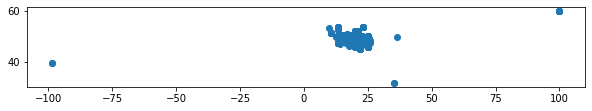

In [85]:
# Domiciles turned into Geopandas data frame
domicgeodf = gpd.GeoDataFrame(
    domicdf, geometry=gpd.points_from_xy(domicdf.lon, domicdf.lat))
domicgeodf.plot()

<AxesSubplot:>

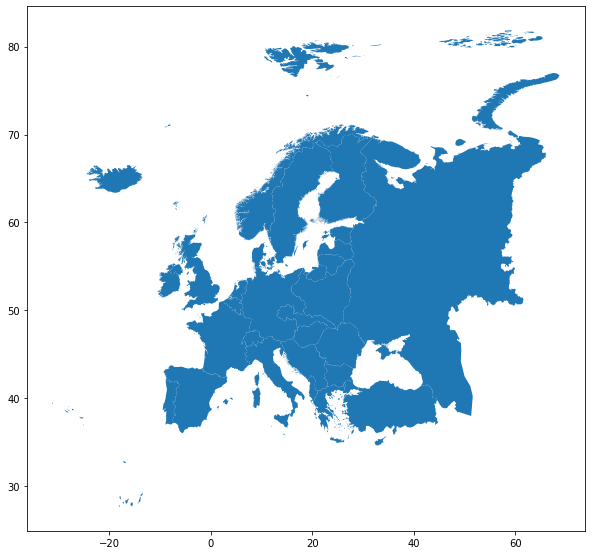

In [84]:
# Load border datasets to Geopandas
b19380331 = gpd.read_file('/home/michal/michal.frankl@gmail.com/michal/GIS/borders19380331_corr.shp')
#b19381130 = gpd.read_file('/home/michal/michal.frankl@gmail.com/michal/GIS/european_borders/November_30_1938.shp')
b19381130 = gpd.read_file('/home/michal/michal.frankl@gmail.com/michal/GIS/borders19381130_corr.shp')
b19381130.plot()

In [79]:
# Projection has to be defined for the domicile table
domicgeodf = domicgeodf.set_crs('EPSG:4326')

In [76]:
# Join domiciles with state borders (displays only a sample of resulting data frame)
statesdom = domicgeodf.sjoin(b19381130, how="left")
statesdom

,location,domicile_citizenship,domicile_geo,lat,lon,geometry,index_right,Name,Foreign_Po,Head_of_St,Govt_in_Ex,Shape_Leng,Shape_Area
0,Žilina,Opava,https://www.geonames.org/3068927/opava.html,49.93866,17.90257,POINT (17.90257 49.93866),36.0,Germany,<Null>,Adolf Hitler (F�hrer),None,1.090608e+07,5.861791e+11
1,Žilina,Opava,https://www.geonames.org/3068927/opava.html,49.93866,17.90257,POINT (17.90257 49.93866),36.0,Germany,<Null>,Adolf Hitler (F�hrer),None,1.090608e+07,5.861791e+11
2,Trenčín,Opava,https://www.geonames.org/3068927/opava.html,49.93866,17.90257,POINT (17.90257 49.93866),36.0,Germany,<Null>,Adolf Hitler (F�hrer),None,1.090608e+07,5.861791e+11
3,Žilina,Opava,https://www.geonames.org/3068927/opava.html,49.93866,17.90257,POINT (17.90257 49.93866),36.0,Germany,<Null>,Adolf Hitler (F�hrer),None,1.090608e+07,5.861791e+11
4,Trenčín,Opava,https://www.geonames.org/3068927/opava.html,49.93866,17.90257,POINT (17.90257 49.93866),36.0,Germany,<Null>,Adolf Hitler (F�hrer),None,1.090608e+07,5.861791e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,Čataj,Čataj,https://www.geonames.org/3060808/cataj.html,48.27049,17.47873,POINT (17.47873 48.27049),1.0,Czecho-Slovakia,None,Emil H�cha (President),<Null>,3.970920e+06,9.770266e+10
2045,Modrý Kameň,"Veľ. Zlievce, okr. Modrý Kameň",https://www.geonames.org/3056847/velke-zlievce...,48.19974,19.45582,POINT (19.45582 48.19974),0.0,Hungary,<Null>,Mikl�s Horthy (Regent),None,2.261526e+06,1.050275e+11
2046,Modrý Kameň,"Filak. Klačany, okr. Lučenec",https://www.geonames.org/3060241/filakovske-kl...,48.29032,19.75301,POINT (19.75301 48.29032),0.0,Hungary,<Null>,Mikl�s Horthy (Regent),None,2.261526e+06,1.050275e+11
2047,Modrý Kameň,"Baračka, okr. Vráble",https://www.geonames.org/3061176/bardonovo.html,48.10874,18.422,POINT (18.42200 48.10874),0.0,Hungary,<Null>,Mikl�s Horthy (Regent),None,2.261526e+06,1.050275e+11


Having joined the datasets spatially, we can group the records according to inter-war state borders.

In [78]:
statesdom.groupby(['Name'])['domicile_citizenship'].count()

Name
Czecho-Slovakia    353
Germany            213
Hungary            485
Poland             862
Romania            117
Soviet Union         1
Yugoslavia           5
Name: domicile_citizenship, dtype: int64

In [100]:
# In addition, find out, how many "Hungarians" were domiciled in the areas annected by Hungary after the First Vienna Award.
huncz = statesdom[statesdom.Name=='Hungary']
huncz = huncz.drop(['index_right'], axis = 1)
huncz = huncz[huncz.Name=='Hungary'].sjoin(b19380331, how="left")
huncz[huncz.Name_right=='Czechoslovakia']

,location,domicile_citizenship,domicile_geo,lat,lon,geometry,Name_left,Foreign_Po_left,Head_of_St_left,Govt_in_Ex_left,Shape_Leng_left,Shape_Area_left,index_right,Name_right,Foreign_Po_right,Head_of_St_right,Govt_in_Ex_right,Shape_Leng_right,Shape_Area_right
1158,Trenčín,Nové Zámky,https://www.geonames.org/3058472/nove-zamky.html,47.98544,18.16195,POINT (18.16195 47.98544),Hungary,<Null>,Mikl�s Horthy (Regent),None,2.261526e+06,1.050275e+11,32,Czechoslovakia,None,Edvard Bene� (President),None,3.636117e+06,1.405859e+11
1159,Trenčín,Nové Zámky,https://www.geonames.org/3058472/nove-zamky.html,47.98544,18.16195,POINT (18.16195 47.98544),Hungary,<Null>,Mikl�s Horthy (Regent),None,2.261526e+06,1.050275e+11,32,Czechoslovakia,None,Edvard Bene� (President),None,3.636117e+06,1.405859e+11
1160,Trenčín,Nové Zámky,https://www.geonames.org/3058472/nove-zamky.html,47.98544,18.16195,POINT (18.16195 47.98544),Hungary,<Null>,Mikl�s Horthy (Regent),None,2.261526e+06,1.050275e+11,32,Czechoslovakia,None,Edvard Bene� (President),None,3.636117e+06,1.405859e+11
1161,Trenčín,Nové Zámky,https://www.geonames.org/3058472/nove-zamky.html,47.98544,18.16195,POINT (18.16195 47.98544),Hungary,<Null>,Mikl�s Horthy (Regent),None,2.261526e+06,1.050275e+11,32,Czechoslovakia,None,Edvard Bene� (President),None,3.636117e+06,1.405859e+11
1162,Trenčín,Nové Zámky,https://www.geonames.org/3058472/nove-zamky.html,47.98544,18.16195,POINT (18.16195 47.98544),Hungary,<Null>,Mikl�s Horthy (Regent),None,2.261526e+06,1.050275e+11,32,Czechoslovakia,None,Edvard Bene� (President),None,3.636117e+06,1.405859e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041,Šarfia,Šarfia,https://www.geonames.org/3061059/blatne.html,48.2666,17.41919,POINT (17.41919 48.26660),Hungary,<Null>,Mikl�s Horthy (Regent),None,2.261526e+06,1.050275e+11,32,Czechoslovakia,None,Edvard Bene� (President),None,3.636117e+06,1.405859e+11
2042,Šarfia,Šarfia,https://www.geonames.org/3061059/blatne.html,48.2666,17.41919,POINT (17.41919 48.26660),Hungary,<Null>,Mikl�s Horthy (Regent),None,2.261526e+06,1.050275e+11,32,Czechoslovakia,None,Edvard Bene� (President),None,3.636117e+06,1.405859e+11
2045,Modrý Kameň,"Veľ. Zlievce, okr. Modrý Kameň",https://www.geonames.org/3056847/velke-zlievce...,48.19974,19.45582,POINT (19.45582 48.19974),Hungary,<Null>,Mikl�s Horthy (Regent),None,2.261526e+06,1.050275e+11,32,Czechoslovakia,None,Edvard Bene� (President),None,3.636117e+06,1.405859e+11
2046,Modrý Kameň,"Filak. Klačany, okr. Lučenec",https://www.geonames.org/3060241/filakovske-kl...,48.29032,19.75301,POINT (19.75301 48.29032),Hungary,<Null>,Mikl�s Horthy (Regent),None,2.261526e+06,1.050275e+11,32,Czechoslovakia,None,Edvard Bene� (President),None,3.636117e+06,1.405859e+11
